Running Through EAZY Py
This is an individual testing notebook, testing one template suite at a time.

catalogue_prepare.ipynb can be used to prepare a catalogue for testing.


In [12]:

%matplotlib inline

import os
import glob
import matplotlib.pyplot as plt
import warnings
import numpy as np
import pandas as pd
from astropy.utils.exceptions import AstropyWarning
import eazy.hdf5
import time
import importlib
import sys
import eazy
import astropy.stats

np.seterr(all='ignore')
warnings.simplefilter('ignore', category=AstropyWarning)
print('EAZYCODE = '+ str(os.getenv('EAZYCODE')) + '\n')

print(time.ctime() + '\n')

print(sys.version + '\n')

for module in ['numpy', 'scipy', 'matplotlib','astropy','eazy']:
    mod = importlib.import_module(module)
    print('{0:>20} : {1}'.format(module, mod.__version__))

EAZYCODE = None

Fri Jul 26 06:15:53 2024

3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)]

               numpy : 1.22.3
               scipy : 1.7.3
          matplotlib : 3.8.0
             astropy : 5.3.4
                eazy : 0.6.8


Basic Settings Cell, can find more in depth changes further down

In [13]:
# Load ZFOURGE catalogue from local drive
test_title = 'test_4' # title of the test, eg. 1,2, A, B, Initial.
field = 'cdfs' #'cdfs', 'cosmos', or 'uds'

# Choose ID key for the catalogue
# A key designates what type of test you want to occur
id_key = 'normal' # normal, high or low

# Directories for key, name keys anything, it is just to keep track of any complex object choices made in catalogue_prepare.ipynb
id_key_dict = {'normal': 'inputs/alternate_catalogues/cdfs.range.(0, -1).cat',
             'fraction': f'inputs/alternate_catalogues/{field}.fraction.bin10.0.cat',
          'luminosity' : f'inputs/alternate_catalogues/{field}.luminosity.bin10.0.cat',
               'ir_agn': f'inputs/alternate_catalogues/{field}.ir_agn.cat',
            'radio_agn': f'inputs/alternate_catalogues/{field}.radio_agn.cat',
             'xray_agn': f'inputs/alternate_catalogues/{field}.xray_agn.cat',
             'only_agn': f'inputs/alternate_catalogues/{field}.only_agn_above_0.1.cat'}

# AGN templates allocation
loop_number = 1 # what loop you are on, however in the test ipy this is not used
agn_sed = [] # AGN templates to be added, comma separated list
use_galaxy_templates = True # set to True to use galaxy templates as well

In [14]:
# finding/creating the output directories

# Directories
if not os.path.isdir(f'outputs/{field}/{test_title}'):
    os.makedirs(f'outputs/{field}/{test_title}')

# Where to Save number data
output_directory = f'outputs/{field}/{test_title}/{field}_{test_title}_{id_key}_{agn_sed}_{use_galaxy_templates}' # output directory for images
key_data_file = f'outputs/{field}/{test_title}/{test_title}_data.csv'
headings = ['id_key', 'zstep', 'loop_number', 'agn_templates', 'galaxy templates', 'total_obj', 'mean_agn_frac', 'spec_count', 'outlier_count', 'nmad_val']

key_data = pd.DataFrame(columns=headings)
if not os.path.isfile(key_data_file):
    key_data.to_csv(key_data_file, index=False)


Loading Templates Function

In [15]:
# Load any templates from the AGN template library

temp_param = 'templates/eazy_v1.3.spectra.param' # basic parameter file, no agn templates
last_id = 9 # last id in the parameter file
empty_param = 'templates/eazy_v1.3_empty.param' # empty parameter file
agn_param = 'templates/eazy_v1.3_AGN.param' # parameter file with agn templates

# opening the parameter files, and reading the contents
with open(temp_param) as f:
    original_galaxy = f.read()

with open(empty_param) as f:
    original_empty = f.read()

agn_dir = 'templates/hlsp_agnsedatlas_rest/' # dir with all agn templates
agn_temp_all = os.listdir(agn_dir)


def agn_template_loader(templates, use_galaxy_templates=False):

    """
    Function to load AGN templates to the parameter file
    templates: list of templates to be added
    use_galaxy_templates: set to True to use galaxy templates as well
    """
    if use_galaxy_templates:
        copy_original_galaxy = original_galaxy
        no_of_templates_added = len(templates)
        if no_of_templates_added == 0:
            open(agn_param, 'w').write(copy_original_galaxy)
            print('No AGN templates added, just using EAZY galaxy templates')
            return
        for i in range(no_of_templates_added):
            current_id = last_id + i
            copy_original_galaxy = copy_original_galaxy + f'\n{current_id}   {agn_dir}{agn_temp_all[templates[i]]}   1.0 0 1.0    '
        open(agn_param, 'w').write(copy_original_galaxy)
        print(f'AGN templates added to the parameter file, {templates}, {agn_param}, {last_id} galaxy templates used')
        return
    else:
        copy_original_galaxy = original_empty
        no_of_templates_added = len(templates)
        if no_of_templates_added == 0:
            open(agn_param, 'w').write(copy_original_galaxy)
            print('No AGN templates added, no Galaxy templates used')
            return
        for i in range(no_of_templates_added):
            current_id = 0 + i
            copy_original_galaxy = copy_original_galaxy + f'\n{current_id}   {agn_dir}{agn_temp_all[templates[i]]}   1.0 0 1.0    '
            open(agn_param, 'w').write(copy_original_galaxy)
            print(f'AGN templates added to the parameter file {agn_param}, no galaxy templates used')
            return



AGN Data Analysis

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.01, 1000.0)

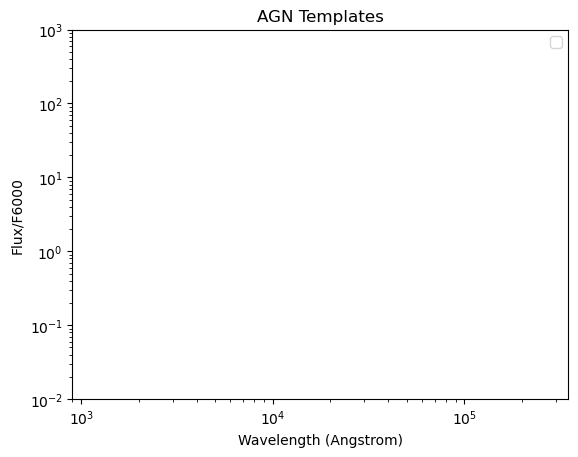

In [16]:
#plotting all the templates used
plt.clf()
for i in range(len(agn_sed)):
    template_data = pd.read_csv(f'{agn_dir}{agn_temp_all[agn_sed[i]]}', sep=' ', header=None)
    flux_position =  abs(template_data[0] - 6000).idxmin()
    flux_normal = template_data[1][flux_position]
    plt.plot(template_data[0], template_data[1] / flux_normal, label=f'{agn_sed[i]}')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux/F6000')
plt.title('AGN Templates')
plt.xlim(900, 35e4)
plt.ylim(1e-2, 1e3)


In [17]:
# Read the catalogue
os.getcwd()

main_cat = pd.read_csv(id_key_dict[id_key]) # get the catalogue for the id_key
main_cat.to_csv('inputs/eazy_test.cat', index=False) # create a new catalogue, allows for change to be made in this cell

#Setting up the main catalogue
main = pd.read_csv('inputs/eazy_test.cat', sep=" ", comment="#", header=None, skipinitialspace=True) # opening cut cat, and adjusting it
headers = pd.read_csv('inputs/eazy_test.cat', sep=" ", header=None, nrows=1).iloc[0]
headers = headers[1:]
main.columns = headers

total_count = len(main) # all objects in the range

In [18]:
# Plot of % influence from AGN on each object

agn_per_dir = f'inputs/{field}_agn_frac.txt' # file with AGN fractions for each object, prepared in catalogue_prepare.ipynb
all_bayes = pd.read_csv(agn_per_dir, sep="\s+", comment='#')

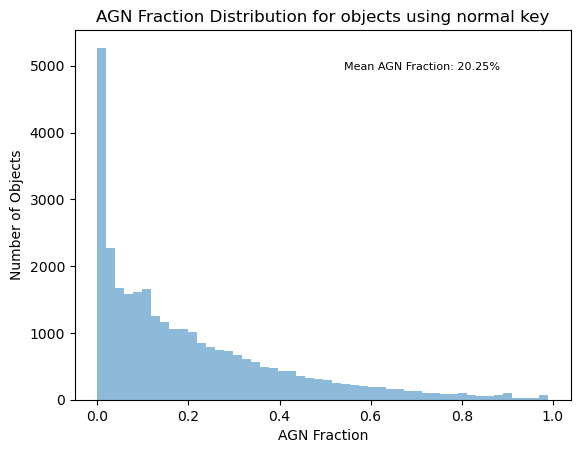

In [19]:
has_fraction = 'bayes.agn.fracAGN' in main.columns
if not has_fraction:
    main = pd.merge(main, all_bayes, on='id', how='left') # AGN fraction for each object

mean_frac = np.mean(main['bayes.agn.fracAGN'])
positive_agn = main[main['bayes.agn.fracAGN'] > 0]

plt.clf()
plt.hist(main['bayes.agn.fracAGN'], bins=50, alpha=0.5, label='AGN Fraction')

plt.xlabel('AGN Fraction')
plt.ylabel('Number of Objects')
plt.title(f'AGN Fraction Distribution for objects using {id_key} key')
plt.text(0.7, 0.9, f'Mean AGN Fraction: {mean_frac:.2%}', fontsize=8, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.savefig(f'outputs/{field}/{test_title}/agn_frac_{field}_{id_key}_{agn_sed}_{use_galaxy_templates}.png')
plt.show()

Running EAZY, some parameters can be changed here, look to the base.param file to adjust more

In [20]:
# EAZY parameters

# following files should be in the same dir as the project
param_file = 'base.param' #base parameter file, does not include all information
translate_file = glob.glob(f'zfourge/{field}/eazy/{field}.*.translate')

agn_template_loader(agn_sed, use_galaxy_templates=use_galaxy_templates) # loads the chosen AGN templates to the parameter file

params = {} # setting field specific parameters
params['Z_STEP'] = 0.05 # redshift step, defines the precision of each fit, 0.005 default

#inputs
params['TEMPLATES_FILE'] = 'templates/eazy_v1.3_AGN.param' # parameter file containing which templates will be used
params['CACHE_FILE'] = f'zfourge/{field}/{field}.tempfilt'
params['CATALOG_FILE'] = f'inputs/eazy_test.cat' # for cut catalogue created in the earlier cell

#outputs
params['MAIN_OUTPUT_FILE'] = output_directory # output directory set earlier


No AGN templates added, just using EAZY galaxy templates


Initialize eazy.photoz.PhotoZ object

In [21]:
# Run EAZY with parameters

self = eazy.photoz.PhotoZ(param_file=param_file, translate_file=translate_file[0], zeropoint_file=None,
                         params=params, load_prior=True, load_products=False)

Read default param file: base.param
Read CATALOG_FILE: inputs/eazy_test.cat
   >>> NOBJ = 30910
f_IRAC_80 e_IRAC_80 ( 21): IRAC/irac_tr4_2004-08-09.dat
f_IRAC_58 e_IRAC_58 ( 20): IRAC/irac_tr3_2004-08-09.dat
f_IRAC_45 e_IRAC_45 ( 19): IRAC/irac_tr2_2004-08-09.dat
f_IRAC_36 e_IRAC_36 ( 18): IRAC/irac_tr1_2004-08-09.dat
f_Ks e_Ks (255): FOURSTAR/Ks_cam_optics_sky.txt
f_KsHI e_KsHI (269): VLT/hawki_k_ETC.dat
f_J1 e_J1 (249): FOURSTAR/J1_cam_optics_sky.txt
f_J2 e_J2 (250): FOURSTAR/J2_cam_optics_sky.txt
f_J3 e_J3 (251): FOURSTAR/J3_cam_optics_sky.txt
f_Hs e_Hs (254): FOURSTAR/Hshort_cam_optics_sky.txt
f_Hl e_Hl (253): FOURSTAR/Hlong_cam_optics_sky.txt
f_U e_U (103): ESO/vimos_u.res
f_B e_B (  1): hst/ACS_update_sep07/wfc_f435w_t77.dat
f_V e_V (  4): hst/ACS_update_sep07/wfc_f606w_t77.dat
f_R e_R (260): ESO/VIMOS/R.dat
f_I e_I (  5): hst/ACS_update_sep07/wfc_f775w_t77.dat
f_Z e_Z (  7): hst/ACS_update_sep07/wfc_f850lp_t77.dat
f_F125W e_F125W (203): hst/wfc3/IR/f125w.dat
f_F140W e_F140W (204

100%|██████████| 9/9 [00:13<00:00,  1.48s/it]


Template   0: eazy_v1.1_sed1.dat (NZ=1).
Template   1: eazy_v1.1_sed2.dat (NZ=1).
Template   2: eazy_v1.1_sed3.dat (NZ=1).
Template   3: eazy_v1.1_sed4.dat (NZ=1).
Template   4: eazy_v1.1_sed5.dat (NZ=1).
Template   5: eazy_v1.1_sed6.dat (NZ=1).
Template   6: eazy_v1.1_sed7.dat (NZ=1).
Template   7: c09_del_8.6_z_0.019_chab_age09.40_av2.0.dat (NZ=1).
Template   8: erb2010_highEW.dat (NZ=1).
Process templates: 14.323 s


48it [00:01, 37.10it/s]


Iterative zeropoint corrections

Iteration:  0


100%|██████████| 48/48 [00:22<00:00,  2.10it/s]


Compute best fits
fit_best: 5.5 s (n_proc=2,  NOBJ=29275)
Fit 28.8 s (n_proc=8, NOBJ=29668)
Iterative correction - zeropoint / template


C:\Users\eddie\anaconda3\envs\SEDTemplate_conda\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Iteration:  1


100%|██████████| 48/48 [00:23<00:00,  2.04it/s]


Compute best fits
fit_best: 6.2 s (n_proc=2,  NOBJ=29288)
Fit 30.2 s (n_proc=8, NOBJ=29668)
Iterative correction - zeropoint / template


C:\Users\eddie\anaconda3\envs\SEDTemplate_conda\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Iteration:  2


100%|██████████| 48/48 [00:23<00:00,  2.07it/s]


Compute best fits
fit_best: 5.5 s (n_proc=2,  NOBJ=29294)
Fit 29.1 s (n_proc=8, NOBJ=29668)
Iterative correction - zeropoint / template


C:\Users\eddie\anaconda3\envs\SEDTemplate_conda\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


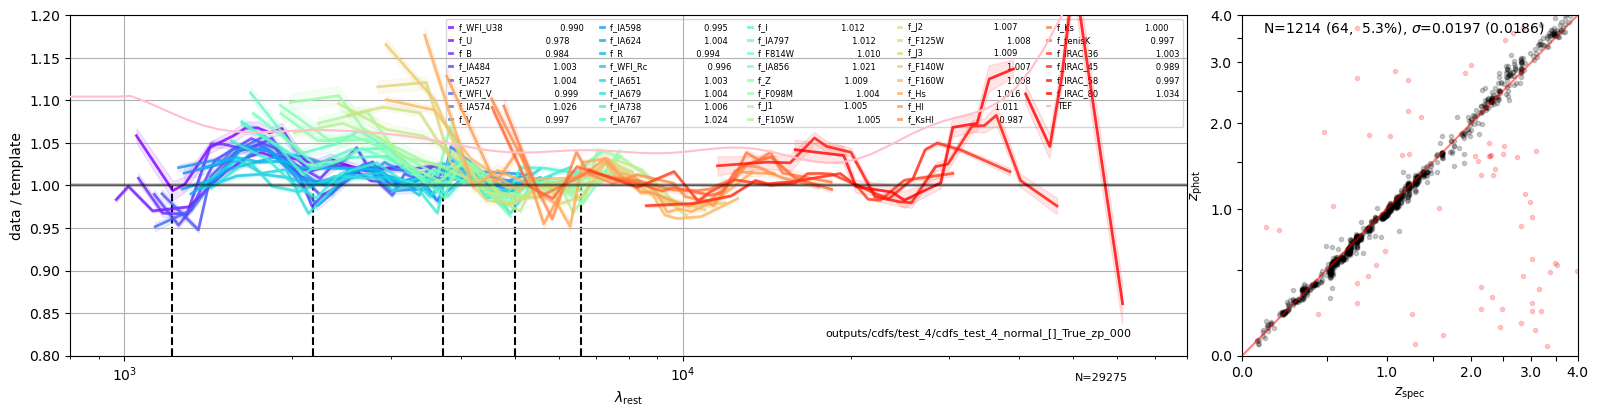

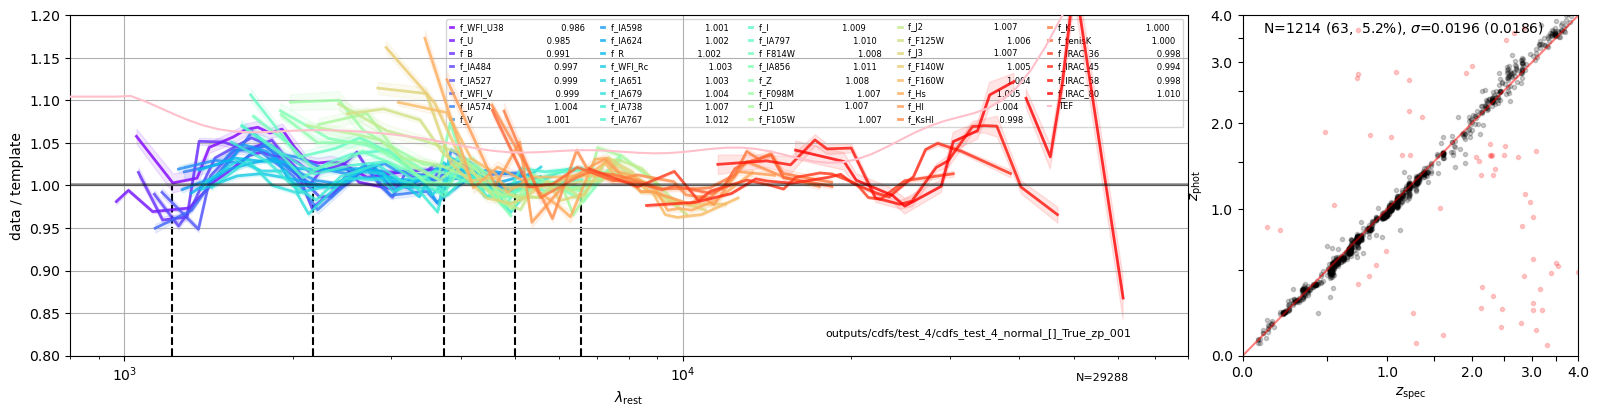

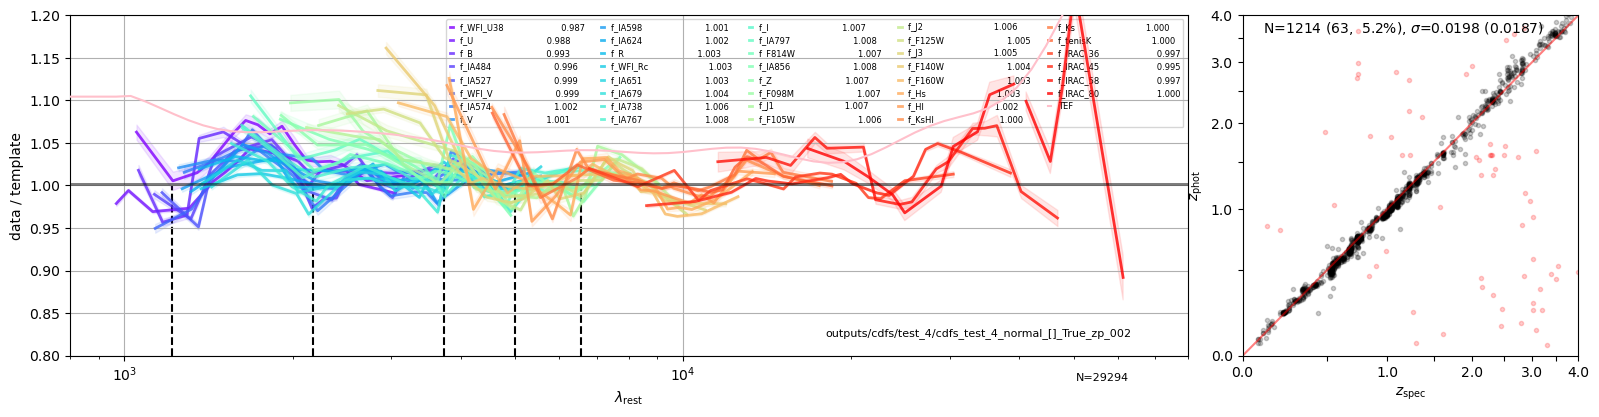

In [22]:
# Iterative Zero-point corrections

NITER = 3 # no. of iterations
NBIN = np.minimum(self.NOBJ//100, 180) # no. of bins

for iter in range(NITER):
    print('Iteration: ', iter)

    sn = self.fnu/self.efnu
    clip = (sn > 1).sum(axis=1) > 4 # Generally make this higher to ensure reasonable fits
    self.iterate_zp_templates(idx=self.idx[clip], update_templates=False,
                              update_zeropoints=True, iter=iter, n_proc=8,
                              save_templates=False, error_residuals=False,
                              NBIN=NBIN, get_spatial_offset=False)

Now fit the whole catalog

Set sys_err = 0.00 (positive=True)


100%|██████████| 48/48 [00:23<00:00,  2.02it/s]


Compute best fits
fit_best: 4.8 s (n_proc=3,  NOBJ=30387)
Fit 29.1 s (n_proc=8, NOBJ=30910)


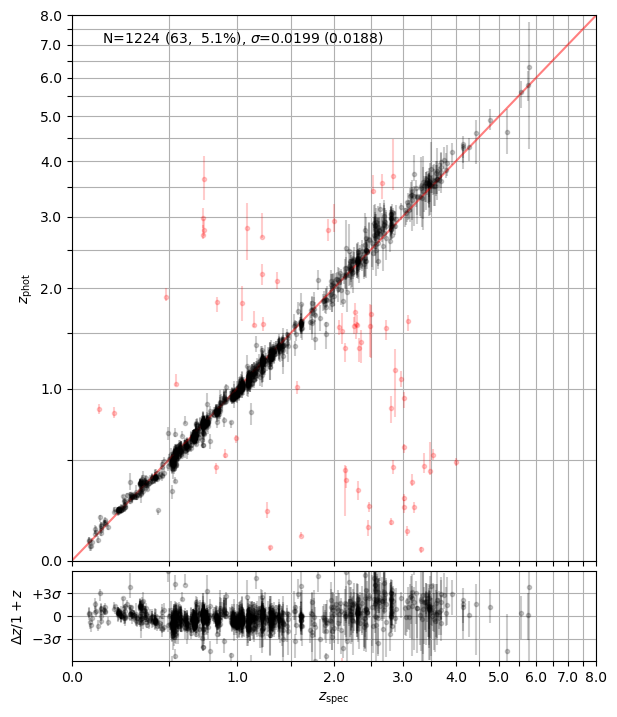

In [23]:
# Turn off error corrections derived above
self.set_sys_err(positive=True)

# Full catalog
sample = np.isfinite(self.ZSPEC)

# fit_parallel renamed to fit_catalog 14 May 2021
self.fit_catalog(self.idx[sample], n_proc=8)

# Show zspec-zphot comparison
zmax = 8
fig = self.zphot_zspec(zmax = zmax)
fig.savefig(f'outputs/{field}/{test_title}/zphot_zspec_{field}_{id_key}_{params["Z_STEP"]}_{agn_sed}_{use_galaxy_templates}.png')

In [24]:
# Derived parameters (z params, RF colors, masses, SFR, etc.)
warnings.simplefilter('ignore', category=RuntimeWarning)
zout, hdu = self.standard_output(simple=False,
                                 rf_pad_width=0.5, rf_max_err=2,
                                 prior=True, beta_prior=True,
                                 absmag_filters=[],
                                 extra_rf_filters=[])

# 'zout' also saved to [MAIN_OUTPUT_FILE].zout.fits

Get best fit coeffs & best redshifts
fit_best: 12.1 s (n_proc=3,  NOBJ=30511)
Get parameters (UBVJ=[153, 154, 155, 161], simple=False)


100%|██████████| 30511/30511 [05:05<00:00, 99.75it/s] 



 Couldn't find template parameters file templates/eazy_v1.3_AGN.param.fits for population synthesis 
 calculations.
            


UVJ Plots

Text(0, 0.5, '$(U-V)_0$')

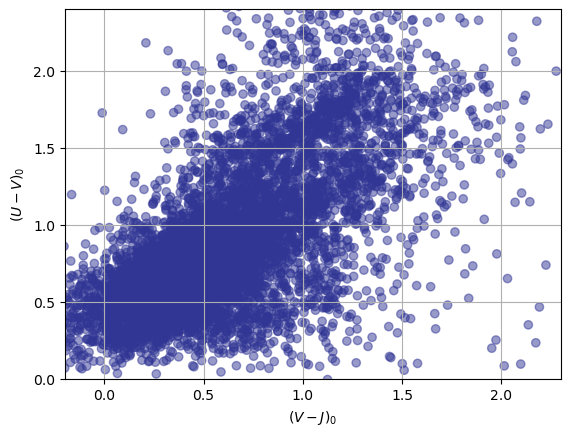

In [25]:
# Show UVJ diagram
uv = -2.5*np.log10(zout['restU']/zout['restV'])
vj = -2.5*np.log10(zout['restV']/zout['restJ'])
ssfr = zout['sfr']/zout['mass']

sel = (zout['z_phot'] > 0.2) & (zout['z_phot'] < 1)
plt.scatter(vj[sel], uv[sel], c=np.log10(ssfr)[sel],
            vmin=-13, vmax=-8, alpha=0.5, cmap='RdYlBu')

plt.xlim(-0.2, 2.3); plt.ylim(0, 2.4); plt.grid()
plt.xlabel(r'$(V-J)_0$'); plt.ylabel(r'$(U-V)_0$')

Array Showing Worst Fits, Used in Graphing

In [26]:
all_zphot_zspec = pd.DataFrame({'id':self.idx, 'zspec':self.ZSPEC, 'zphot':self.zbest, 'agn_fraction':main['bayes.agn.fracAGN']})
all_zphot_zspec = all_zphot_zspec[all_zphot_zspec['zspec'] > 0.005] #setting minimums for the redshifts
all_zphot_zspec = all_zphot_zspec[all_zphot_zspec['zphot'] > 0.02]
all_zphot_zspec['compare'] = (all_zphot_zspec['zphot'] - all_zphot_zspec['zspec']) / ( 1 + all_zphot_zspec['zspec'])


Colour Colour

In [27]:
#Colour Plot with each template (maybe a range around them), and then each object plotted, to see how well these templates cover the objects, in the observed frame

colours = ['U', 'V', 'J1', 'J2', 'J3'] # colours to be used, dictates loops and filter responses
columns = ['id', 'agn_fraction', 'red_diff'] + colours # columns to be used in the dataframe
used_colours = pd.DataFrame(columns=columns)

for i in range(len(colours)):
    used_colours[colours[i]] = main[f'f_{colours[i]}']

used_colours['id'] = main['id']
used_colours['agn_fraction'] = main['bayes.agn.fracAGN']
used_colours['red_diff'] = all_zphot_zspec['compare']

no_negative_mask = ~used_colours[colours].lt(0).any(axis=1)
used_colours = used_colours[no_negative_mask] #remove -99 values


# UVJ colours
def axis_math(colour1, colour2):
    return abs(np.log10(colour1 / colour2))

used_colours['UV'] = axis_math(used_colours['U'], used_colours['V'])
used_colours['VJ'] = axis_math(used_colours['V'], np.mean(used_colours[['J1', 'J2', 'J3']], axis=1))

#Template colours
class FieldFilters: # class to store filter wavelengths, EAZY will have a big file containing all filters, should dig around there
  def __init__(self, filter_wavelengths):
    self.filter_wavelengths = filter_wavelengths

cdfs_filters = {'B': 4318, 'I': 7693, 'R': 6443, 'U': 3749, 'V': 5919, 'Z': 9036, 'Hs': 15544, 'Hl': 17020, 'J1': 10540, 'J2': 11448, 'J3': 12802, 'Ks': 21538}
cdfs_filters = FieldFilters(cdfs_filters)


def template_colour_redshift(template, redshift):
    """
    Function to calculate the UVJ colours of a template at a given redshift
    template: template number
    redshift: redshift of the object
    """

    template_data_pre = pd.read_csv(f'{agn_dir}{agn_temp_all[template]}', sep=' ', header=None)

    template_data_shifted = pd.DataFrame(columns=['wavelength', 'flux'])
    template_data_shifted['wavelength']= (redshift * template_data_pre[0]) + template_data_pre[0] #redshifting the template
    template_data_shifted['flux'] = template_data_pre[1]

    temp_filt_flux_all = pd.DataFrame(columns=[colours])

    for j in range(len(colours)):
        min_location = abs(template_data_shifted['wavelength'] - cdfs_filters.filter_wavelengths[colours[j]]).idxmin()
        temp_filt_flux = template_data_shifted['flux'][min_location]
        temp_filt_flux_all[colours[j]] = [temp_filt_flux]

    return temp_filt_flux_all

Text(0.5, 1.0, 'UVJ Plot with Redshift Difference')

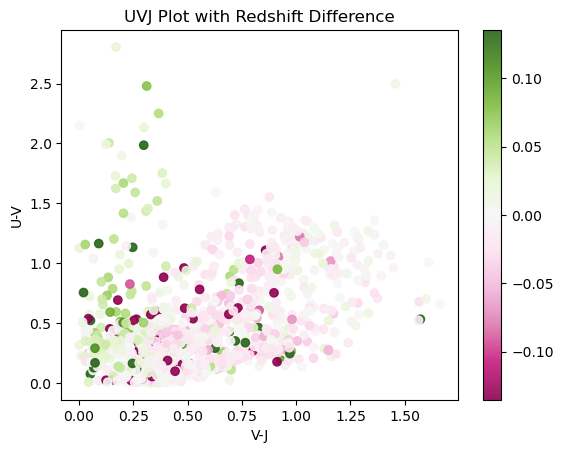

In [28]:
# UVJ plot
import matplotlib.colors as colors

plt.clf()
three_sig_limit = used_colours['red_diff'].std(ddof=3)
norm = colors.Normalize(vmin=-three_sig_limit, vmax=three_sig_limit)

plt.scatter(used_colours['VJ'], used_colours['UV'], c=used_colours['red_diff'], cmap='PiYG', norm=norm, alpha=0.9)
#plt.xlim(0, 2.5)
#plt.ylim(0, 2.5)
plt.colorbar()

plt.xlabel('V-J')
plt.ylabel('U-V')
plt.title('UVJ Plot with Redshift Difference')

Text(0.5, 1.0, 'UVJ Plot with AGN Fraction')

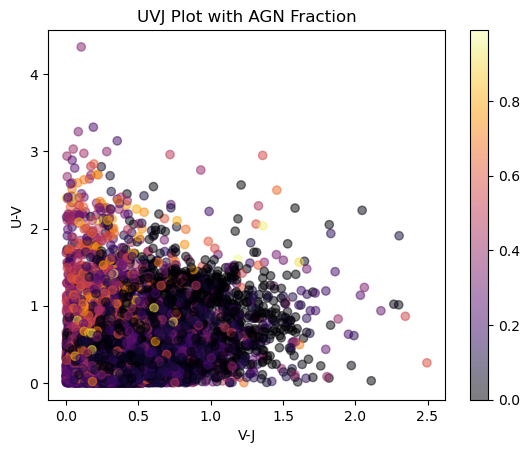

In [29]:
# UVJ plot
plt.clf()
plt.scatter(used_colours['VJ'], used_colours['UV'], c=used_colours['agn_fraction'], cmap='inferno', alpha=0.5)
#plt.xlim(0, 2.5)
#plt.ylim(0, 2.5)
plt.colorbar()

plt.xlabel('V-J')
plt.ylabel('U-V')
plt.title('UVJ Plot with AGN Fraction')

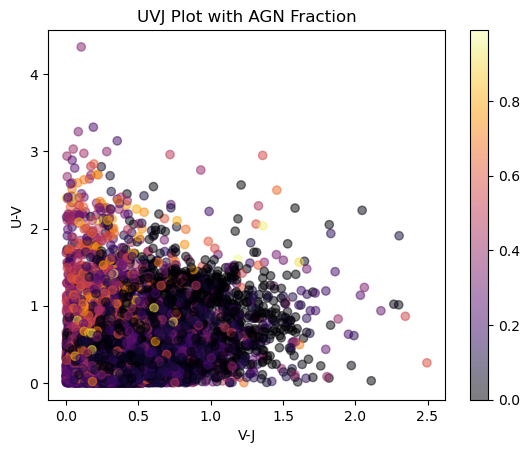

In [30]:
# UVJ plot
plt.clf()
plt.scatter(used_colours['VJ'], used_colours['UV'], c=used_colours['agn_fraction'], cmap='inferno', alpha=0.5)
#plt.xlim(0, 2.5)
#plt.ylim(0, 2.5)
plt.colorbar()

plt.xlabel('V-J')
plt.ylabel('U-V')
plt.title('UVJ Plot with AGN Fraction')

templates_graph = agn_sed # templates to be plotted
redshift_graph = np.linspace(0, 5, 50) # redshifts to be plotted
for i in range(len(templates_graph)):
    for j in range(len(redshift_graph)):
        temp_redshift = template_colour_redshift(templates_graph[i], redshift_graph[j])
        temp_redshift.to_numpy()
        temp_redshift['y_axis'] = axis_math(temp_redshift['U'].values[0], temp_redshift['V'].values[0])
        j_values = temp_redshift[['J1', 'J2', 'J3']].to_numpy()
        j_mean = np.mean(j_values)
        temp_redshift['x_axis'] = axis_math(temp_redshift['V'].values[0], j_mean)
        plt.plot(temp_redshift['y_axis'], temp_redshift['x_axis'],marker='o', c='green')




Redshift Plot with AGN fraction

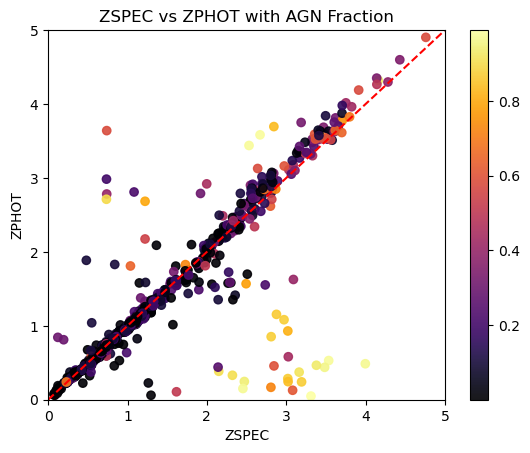

In [31]:
plt.clf()
plt.scatter(all_zphot_zspec['zspec'],
            all_zphot_zspec['zphot'],
            c=all_zphot_zspec['agn_fraction'], cmap='inferno', alpha=0.9, label='AGN Fraction')
plt.plot([0, 6], [0, 6], 'r--')
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel('ZSPEC')
plt.ylabel('ZPHOT')
plt.title('ZSPEC vs ZPHOT with AGN Fraction')
plt.colorbar()


RedShift Difference Vs AGN Fraction

Text(0.5, 1.0, 'Redshift Difference with AGN Fraction')

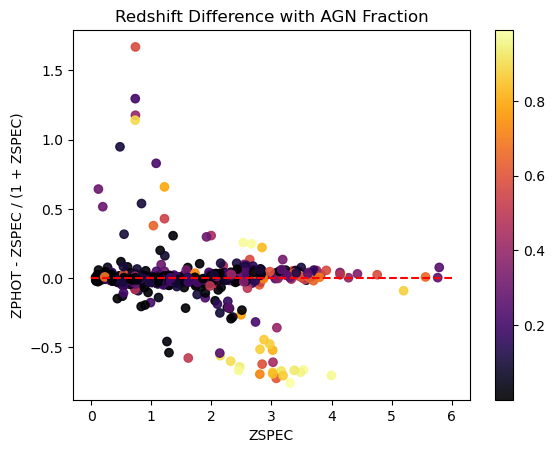

In [32]:
plt.clf()
plt.scatter(all_zphot_zspec['zspec'],
            all_zphot_zspec['compare'],
            c=all_zphot_zspec['agn_fraction'], cmap='inferno', alpha=0.9, label='AGN Fraction')
plt.plot([0, 6], [0, 0], 'r--')
#plt.xlim(0, 6)
#plt.ylim(-0.8, 0.8)
plt.colorbar()
plt.xlabel('ZSPEC')
plt.ylabel('ZPHOT - ZSPEC / (1 + ZSPEC)')
plt.title('Redshift Difference with AGN Fraction')

Calculating NMAD in bins

In [34]:
main['ZSPEC'] = self.ZSPEC; main['ZPHOT'] = self.zbest # adding zspec and zphot to the agn_frac df
main['chi2'] = self.chi2_best / self.NFILT # adding chi2/N to the main df

#sort main df by zspec
main_red = main[main['ZSPEC'] > 0] # filter
main_red = main_red[main_red['ZPHOT'] > 0.02] # filter
main_red = main_red[main_red['ZSPEC'] <= 6] # filter
main_red = main_red.sort_values(by='ZSPEC') # sort

#sort main df by agn fraction
main_agn = main_red.dropna(subset=['bayes.agn.fracAGN']) # filter
main_agn = main_agn.sort_values(by='bayes.agn.fracAGN') # sort

#total NMAD
zspec_nmad = np.array(main_red['ZSPEC'])
zphot_nmad = np.array(main_red['ZPHOT'])
dz = (zphot_nmad - zspec_nmad) / (1 + zspec_nmad)
total_nmad = astropy.stats.mad_std(dz)
print(f'Total NMAD: {total_nmad}')

#outliers
spec_count = len(dz)
catastrophic_limit = 0.15 # catastrophic_limit in eazy code
outliers = np.abs(dz) >= catastrophic_limit
outliers_count = sum(outliers)
print(f'Total Outliers:{outliers_count}')

no_of_bins = 15 # no. of bins

Total NMAD: 0.019863030992036016
Total Outliers:63


Counts: [  5  11   5  26  28  61 101 285 139 229  70 103  99  56   6]
Total: 1224
NMAD: [0.014014755094177196, 0.01751455339015074, 0.0030662417931455253, 0.005696404915608628, 0.011056030865109256, 0.015264690791453893, 0.02015252185104783, 0.015852753672652008, 0.013475661491220979, 0.014442253308744643, 0.01861957838614951, 0.029387077803804132, 0.042989797769482155, 0.0232856099154687, 0.024028002731131346]
Outliers: [0.0, 0.09090909090909091, 0.0, 0.038461538461538464, 0.0, 0.0, 0.019801980198019802, 0.014035087719298246, 0.02877697841726619, 0.034934497816593885, 0.02857142857142857, 0.13592233009708737, 0.21212121212121213, 0.08928571428571429, 0.0]
Fits: [0.88322866, 0.7676742, 0.783426, 0.9006026, 0.7035385, 0.6065062, 0.744895, 0.70901227, 0.60264504, 0.6660763, 0.7080524, 0.9445395, 1.0354179, 1.2966729, 1.0605283]


<Figure size 640x480 with 0 Axes>

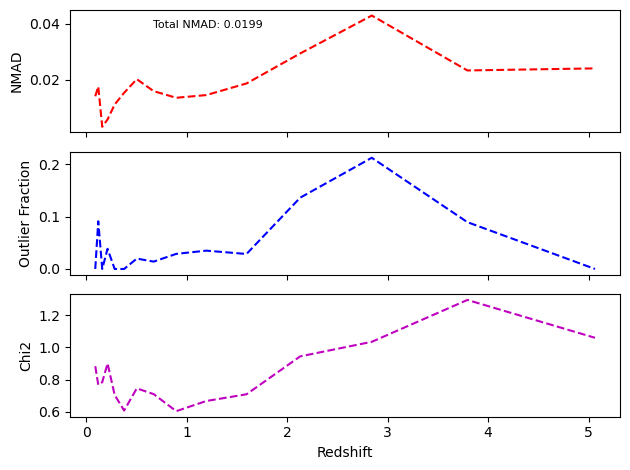

In [35]:

logbins_start = np.log10(min(main_red['ZSPEC'])) # using logarithmic bins
logbins_end = np.log10(max(main_red['ZSPEC'])) + 1e-10 # adding a small value to include the last value
logbins = np.logspace(logbins_start, logbins_end, num=no_of_bins+1)
counts_red, bins_red = np.histogram(main_red['ZSPEC'], bins=logbins)
print(f'Counts: {counts_red}')
print(f'Total: {len(main_red["ZSPEC"])}')
bin_centers_red = (np.array(bins_red[:-1]) + np.array(bins_red[1:])) / 2

last_val = 0 # last val is the first value within a bin (say object 2334), while new val is the last
nmad_red_val = []
outlier_frac_red = []
chi2_red = []
for bin_loop in range(no_of_bins):
    new_val = last_val + counts_red[bin_loop]-1
    zspec_val = main_red['ZSPEC'][last_val:new_val]
    zphot_val = main_red['ZPHOT'][last_val:new_val]
    dz = (np.array(zphot_val) - np.array(zspec_val)) / (1 + np.array(zspec_val))
    nmad_red_val.append(astropy.stats.mad_std(dz)) # NMAD
    outliers_bin = np.abs(dz) >= catastrophic_limit
    bin_fraction = sum(outliers_bin) / counts_red[bin_loop]
    outlier_frac_red.append(bin_fraction)
    chi2_med = np.median(main_red['chi2'][last_val:new_val]) # chi2
    chi2_red.append(chi2_med)
    last_val = new_val + 1 # adding 1 to skip the last value of the previous bin

print(f'NMAD: {nmad_red_val}')
print(f'Outliers: {outlier_frac_red}')
print(f'Fits: {chi2_red}')

plt.clf()
fig, ax = plt.subplots(3, 1, sharex=True)

# NMAD
ax[0].plot(bin_centers_red, nmad_red_val, 'r--')
ax[0].set_ylabel('NMAD')
ax[0].text(0.25, 3.2, f'Total NMAD: {total_nmad:.4f}', fontsize=8, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

# Outliers
ax[1].plot(bin_centers_red, outlier_frac_red, 'b--')
ax[1].set_ylabel('Outlier Fraction')

# Chi2
ax[2].plot(bin_centers_red, chi2_red, 'm--')
ax[2].set_xlabel('Redshift')
ax[2].set_ylabel('Chi2')

fig.tight_layout()

plt.savefig(f'outputs/{field}/{test_title}/RED_{field}_{id_key}_{params["Z_STEP"]}_{agn_sed}_{use_galaxy_templates}.png')
plt.show()

Counts: [660 201  87  94  54  21  21  15  12  11  10   3   5  10  11]
NMAD: [0.01788350884029049, 0.018334348953874112, 0.014527466931501991, 0.024086921938400445, 0.02838122960710889, 0.029554521437504404, 0.02443698769184659, 0.035351542825151315, 0.035064728912986697, 0.048742644696725956, 0.01720220894605212, 0.015412350559914873, 0.6760347988772616, 0.12714962334845156, 0.045554408960774805]
Outliers: [0.42272727272727273, 0.48756218905472637, 0.42528735632183906, 0.5531914893617021, 0.5555555555555556, 0.6190476190476191, 0.6666666666666666, 0.6, 0.5, 0.7272727272727273, 0.3, 0.3333333333333333, 0.8, 0.9, 0.9090909090909091]
Fits: [0.7006405, 0.739757, 0.74524534, 0.75061214, 0.90513414, 0.82562506, 1.1856506, 1.102754, 1.7370658, 1.9772203, 1.891939, 4.458844, 0.8965514, 0.847606, 1.3776612]


<Figure size 640x480 with 0 Axes>

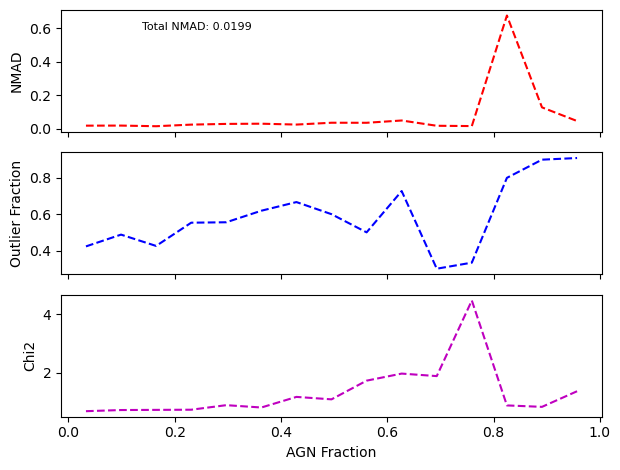

In [36]:
#NMAD against AGN fraction

counts_agn, bins_agn = np.histogram(main_agn['bayes.agn.fracAGN'], bins=no_of_bins)
print(f'Counts: {counts_agn}')
bin_centers_agn = (np.array(bins_agn[:-1]) + np.array(bins_agn[1:])) / 2

last_val = 0 # last val is the first value within a bin (say object 2334), while new val is the last
nmad_agn_val = []
outlier_frac_agn = []
chi2_agn = []
for bin_loop in range(no_of_bins):
    new_val = last_val + counts_agn[bin_loop]-1
    zspec_val = main_agn['ZSPEC'][last_val:new_val]
    zphot_val = main_agn['ZPHOT'][last_val:new_val]
    dz = (np.array(zphot_val) - np.array(zspec_val)) / (1 + np.array(zspec_val))
    nmad_agn_val.append(astropy.stats.mad_std(dz)) # NMAD
    outliers_bin = np.abs(dz) >= 0.015 # outlier
    bin_fraction = sum(outliers_bin) / counts_agn[bin_loop]
    outlier_frac_agn.append(bin_fraction)
    chi2_med = np.median(main_agn['chi2'][last_val:new_val]) # chi2
    chi2_agn.append(chi2_med)
    last_val = new_val + 1 # adding 1 to skip the last value of the previous bin

print(f'NMAD: {nmad_agn_val}')
print(f'Outliers: {outlier_frac_agn}')
print(f'Fits: {chi2_agn}')

plt.clf()
fig, ax = plt.subplots(3, 1, sharex=True)

# NMAD
ax[0].plot(bin_centers_agn, nmad_agn_val, 'r--')
ax[0].set_ylabel('NMAD')
ax[0].text(0.25, 3.2, f'Total NMAD: {total_nmad:.4f}', fontsize=8, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

# Outliers
ax[1].plot(bin_centers_agn, outlier_frac_agn, 'b--')
ax[1].set_ylabel('Outlier Fraction')

# Chi2
ax[2].plot(bin_centers_agn, chi2_agn, 'm--')
ax[2].set_xlabel('AGN Fraction')
ax[2].set_ylabel('Chi2')

fig.tight_layout()

plt.savefig(f'outputs/{field}/{test_title}/AGN_{field}_{id_key}_{params["Z_STEP"]}_{agn_sed}_{use_galaxy_templates}.png')
plt.show()

Redshift Vs AGN Fraction

In [37]:
delta_z = (np.array(main_agn['ZPHOT']) - np.array(main_agn['ZSPEC'])) / (1 + np.array(main_agn['ZSPEC']))
red_agn_plot = pd.DataFrame(columns=['delta_z', 'agn_fraction'])
red_agn_plot['delta_z'] = delta_z
agn_fraction = main_agn['bayes.agn.fracAGN']
agn_fraction.index = range(len(agn_fraction))
red_agn_plot['agn_fraction'] = agn_fraction
red_agn_plot = red_agn_plot.sort_values(by=['agn_fraction'])
#red_agn_plot = red_agn_plot[abs(red_agn_plot['delta_z']) <= catastrophic_limit]

no_of_bins_red_agn = 30
bin_edges = pd.qcut(red_agn_plot['agn_fraction'], no_of_bins_red_agn)
bin_edges = bin_edges.cat.categories
red_agn_bins = np.zeros([no_of_bins_red_agn, 2])

for i in range(no_of_bins_red_agn):
    min_loop = bin_edges[i].left
    max_loop = bin_edges[i].right
    bin_values = red_agn_plot[(red_agn_plot['agn_fraction'] >= min_loop) & (red_agn_plot['agn_fraction'] <= max_loop)]
    red_agn_bins[i, 0] = np.mean(bin_values['delta_z'])
    red_agn_bins[i, 1] = np.mean(bin_values['agn_fraction'])

Text(0.5, 1.0, 'Redshift vs AGN Fraction')

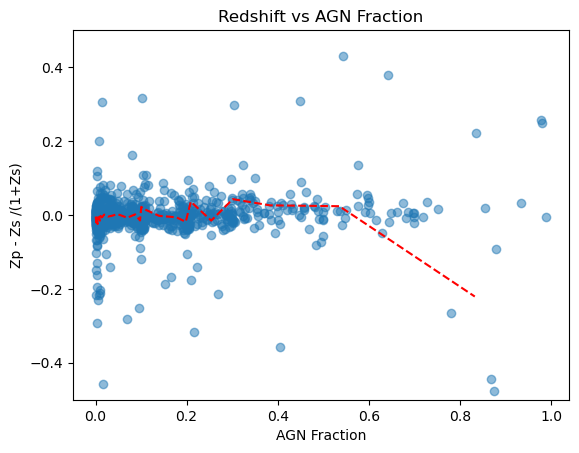

In [38]:
plt.clf()
plt.scatter(red_agn_plot['agn_fraction'], red_agn_plot['delta_z'], alpha=0.5)
plt.plot(red_agn_bins[:, 1], red_agn_bins[:, 0], 'r--')
plt.ylim(-0.5, 0.5)
plt.xlabel('AGN Fraction')
plt.ylabel('Zp - Zs /(1+Zs)')
plt.title('Redshift vs AGN Fraction')

Residuals

In [39]:
#limit the no of objects to those that are present in all bands, and have a positive redshift
flux_observed = []
flux_residual_objects = []
#any(self.fnu[i] == -99) or
for i in range(len(self.fnu)):
    if self.zbest[i] < 0.001:
        continue
    else:
        flux_observed.append(self.fnu[i])
        flux_residual_objects.append(i)
flux_observed = np.array(flux_observed)

#find the residuals of the objects
flux_model = self.fmodel
flux_residual = np.zeros_like(flux_observed)
residual_uncertainties = []
for row in range(len(flux_residual_objects)):
    im = flux_residual_objects[row]
    residual_uncertainties.append(self.efnu[im] / flux_observed[row])
    for col in range(flux_observed.shape[1]): #no. of bands
        if flux_observed[row,col] == -99: # if the flux is -99, it is not recorded and should not be shown as such
            continue
        else:
            flux_residual[row,col] = (flux_observed[row,col] - flux_model[im,col]) / flux_observed[row,col]
residual_uncertainties = np.array(residual_uncertainties)

#redshift the objects
object_redshifted = []
pivots = self.pivot
for i in range(len(flux_residual_objects)):
    im = flux_residual_objects[i]
    redshifted = pivots / (1 + self.zbest[im])
    object_redshifted.append(redshifted)
object_redshifted = np.array(object_redshifted)


In [40]:
#plot the residuals
wavelength_flat = object_redshifted.flatten()
residual_flat = flux_residual.flatten()
uncertainties_flat = residual_uncertainties.flatten()

#binning
obj_per_bin = 2000 #EAZY used 2000
no_of_bins_res = np.ceil(len(residual_flat) // obj_per_bin)
res_sorted = pd.DataFrame({'wavelength':wavelength_flat, 'residual':residual_flat, 'uncertainties':uncertainties_flat})
res_sorted = res_sorted.sort_values(by='wavelength')
res_sorted = res_sorted.loc[res_sorted['residual'] != -99]
res_sorted = res_sorted.reset_index(drop=True)
res_sorted_copy = res_sorted # not abs
res_sorted = abs(res_sorted)
res_bin = pd.DataFrame(columns=["Median Residuals", "Median Wavelength", "Median Uncertainties", "Confidence"])
res_bin_copy = pd.DataFrame(columns=["Median Residuals", "Median Wavelength", "Median Uncertainties", 'Confidence'])
for i in range(int(no_of_bins_res)):
    min_loop = i * obj_per_bin
    max_loop = ((i+1) * obj_per_bin) - 1
    med_res = np.median(res_sorted['residual'][min_loop:max_loop])
    med_res_copy = np.median(res_sorted_copy['residual'][min_loop:max_loop]) # only the residuals should be affected by abs
    med_wave = np.median(res_sorted['wavelength'][min_loop:max_loop])
    med_unc = np.median(res_sorted['uncertainties'][min_loop:max_loop])
    confidence =  (50/68.2) * np.std(res_sorted['residual'][min_loop:max_loop]) # want 50% confidence interval, not 1sigma
    res_bin.loc[i] = [med_res, med_wave, med_unc, confidence]
    res_bin_copy.loc[i] = [med_res_copy, med_wave, med_unc, confidence]

<Figure size 640x480 with 0 Axes>

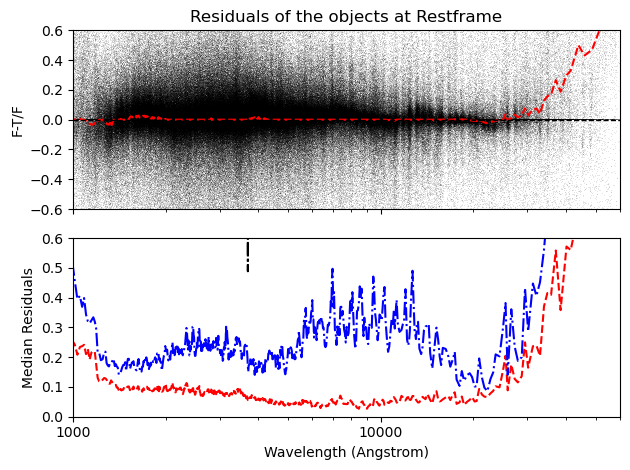

In [41]:
plt.clf()
fig, ax = plt.subplots(2, 1, sharex=True)
fig.gca().set_xscale('log')
fig.gca().xaxis.set_major_formatter('{x:.0f}')

ax[0].plot(wavelength_flat, residual_flat, 'k,', alpha=0.1)
ax[0].plot(res_bin_copy["Median Wavelength"], res_bin_copy["Median Residuals"], 'r--')
ax[0].axhline(y=0, color='black', linestyle='--', linewidth=1)
ax[0].set_ylim(-0.6, 0.6)
ax[0].set_xlim(1e3, 6e4)
ax[0].set_ylabel('F-T/F')
ax[0].set_title('Residuals of the objects at Restframe')

ax[1].plot(res_bin["Median Wavelength"], res_bin["Median Residuals"], 'r--')
ax[1].plot(res_bin["Median Wavelength"], res_bin["Median Uncertainties"], 'b-.')
ax[1].plot(res_bin["Median Wavelength"], res_bin["Confidence"], 'k-.')
ax[1].set_ylim(0, 0.6)
ax[1].set_ylabel('Median Residuals')
ax[1].set_xlabel('Wavelength (Angstrom)')

fig.tight_layout()

plt.savefig(f'outputs/{field}/{test_title}/residuals_{field}_{id_key}_{params["Z_STEP"]}_{agn_sed}_{use_galaxy_templates}.png')
plt.show()

Saving Key data to csv and h5

In [42]:
induvidual_data = pd.DataFrame(columns=['id', 'phot_redshift', 'chi2'])
induvidual_data['id'] = self.idx
induvidual_data['phot_redshift'] = self.zbest
induvidual_data['chi2'] = self.chi2_best
for i in range(self.fmodel.shape[1]):
    induvidual_data[f'band_{i}'] = self.fmodel[:,i]
induvidual_data.to_csv(f'outputs/{field}/{test_title}/induvidual_data_{field}_{id_key}_{params["Z_STEP"]}_{agn_sed}_{use_galaxy_templates}.csv', index=False)

In [47]:
key_data = pd.DataFrame(columns=headings)
key_data.loc[0] = [id_key, params['Z_STEP'], loop_number, agn_sed, use_galaxy_templates, total_count, mean_frac, spec_count, outliers_count, total_nmad]
key_data.to_csv(key_data_file, mode='a', index=False, header=False)

In [48]:
eazy.hdf5.write_hdf5(self, h5file=output_directory + '.h5')

h5: create file outputs/cdfs/test_4/cdfs_test_4_normal_[]_True.h5
h5: cat/flux_columns
h5: cat/err_columns
h5: cat/f_numbers
h5: cat/fnu
h5: cat/efnu_orig
h5: cat/ok_data
h5: cat/zp
h5: cat/ext_corr
h5: cat/ext_redden
h5: cat/pivot
h5: fit/zml
h5: fit/zbest
h5: fit/chi2_fit
h5: fit/coeffs_best
h5: fit/fit_coeffs
h5: templates/eazy_v1.1_sed1.dat
h5: templates/eazy_v1.1_sed2.dat
h5: templates/eazy_v1.1_sed3.dat
h5: templates/eazy_v1.1_sed4.dat
h5: templates/eazy_v1.1_sed5.dat
h5: templates/eazy_v1.1_sed6.dat
h5: templates/eazy_v1.1_sed7.dat
h5: templates/c09_del_8.6_z_0.019_chab_age09.40_av2.0.dat
h5: templates/erb2010_highEW.dat
